In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import rasterio
from scipy.interpolate import griddata

# import geopandas as gpd

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib import pyplot as p

import cmocean # Beautiful colormaps for oceanography
import cmocean.cm as cmo
import os
import matplotlib.patheffects as path_effects

from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from netCDF4 import Dataset as NetCDFFile 

from obspy.imaging.beachball import beach

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from matplotlib.patches import Polygon

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

import shapefile as shp

from shapely.geometry import LineString

# set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [108]:
data = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/ryu_kur_class_by_loc_net.csv", header = 'infer')
# data_mariana = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/mariana_class_by_loc_net.csv", header =None)

In [109]:
# data_mariana.columns = data_ryu_kur.columns
## combine two datasets
# data = pd.concat([data_ryu_kur, data_mariana], ignore_index=True)

In [110]:
# data.dtypes

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

In [111]:
data_dw_mthrust = data[(data['CLASS'] != 'UPPER')]

data_mthrust = data[(data['CLASS'] == 'MTHRUST')]


data_DW = data[(data['CLASS'] == 'DGOING') &
               (data['DEPTH'] > 70)] 

In [113]:
# rupture outline
rup_2011 = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/rijsingen_eq/scraped/kur_rup/kur_sqk_00_rup.csv",
                      skiprows=1)
# rup_2011.coulmns = ['LON', 'LAT']
rup_2011.head()

,LON,LAT
0,143.904052,38.863943
1,143.959203,38.830751
2,143.991793,38.804383
3,144.020622,38.771164
4,144.031903,38.739885


In [114]:
# plate boundary data

sf = shp.Reader("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/PB2002_boundaries.shp")

In [115]:
# topography

# Define the GeoTIFF file path
topo = "/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/etopo-japan.tiff"

# Open the GeoTIFF file using rasterio
with rasterio.open(topo) as src:
    # Read the topography data and extract the extent
    topography_data = src.read(1)  # Read the first band (adjust as needed)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

In [116]:
## Kuril kamchatka slab

slab_kk = NetCDFFile("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/kur_slab2_dep_02.24.18.grd")
# print(type(slab)) # print the type of the data 
# print(slab.variables.keys()) # print the variables in the data

lon_slab_kk = slab_kk.variables['x'][:]
lat_slab_kk = slab_kk.variables['y'][:]
depth_slab_kk = slab_kk.variables['z'][:]
depth_slab_kk = depth_slab_kk*-1

# creating meshgrid from our list of spatial coordinates
lon_slab_kk, lat_slab_kk = np.meshgrid(lon_slab_kk, lat_slab_kk)

In [117]:
## Ryukia Nankai slab

slab_ryu = NetCDFFile("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/ryu_slab2_dep_02.26.18.grd")
# print(type(slab)) # print the type of the data 
# print(slab.variables.keys()) # print the variables in the data

lon_slab_ryu = slab_ryu.variables['x'][:]
lat_slab_ryu = slab_ryu.variables['y'][:]
depth_slab_ryu = slab_ryu.variables['z'][:]
depth_slab_ryu = depth_slab_ryu*-1

# creating meshgrid from our list of spatial coordinates
lon_slab_ryu, lat_slab_ryu = np.meshgrid(lon_slab_ryu, lat_slab_ryu)

In [118]:
## Izu-Bonin slab

slab_izu = NetCDFFile("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/izu_slab2_dep_02.24.18.grd")
# print(type(slab)) # print the type of the data 
# print(slab.variables.keys()) # print the variables in the data

lon_slab_izu = slab_izu.variables['x'][:]
lat_slab_izu = slab_izu.variables['y'][:]
depth_slab_izu = slab_izu.variables['z'][:]
depth_slab_izu = depth_slab_izu*-1

# creating meshgrid from our list of spatial coordinates
lon_slab_izu, lat_slab_izu = np.meshgrid(lon_slab_izu, lat_slab_izu)

In [119]:
import xarray as xr

## plate age

plate_age = xr.open_dataset("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/japan-age.grd")

lon = plate_age.variables['lon'][:]
lat = plate_age.variables['lat'][:]
age = plate_age.variables['z'][:]

## Map

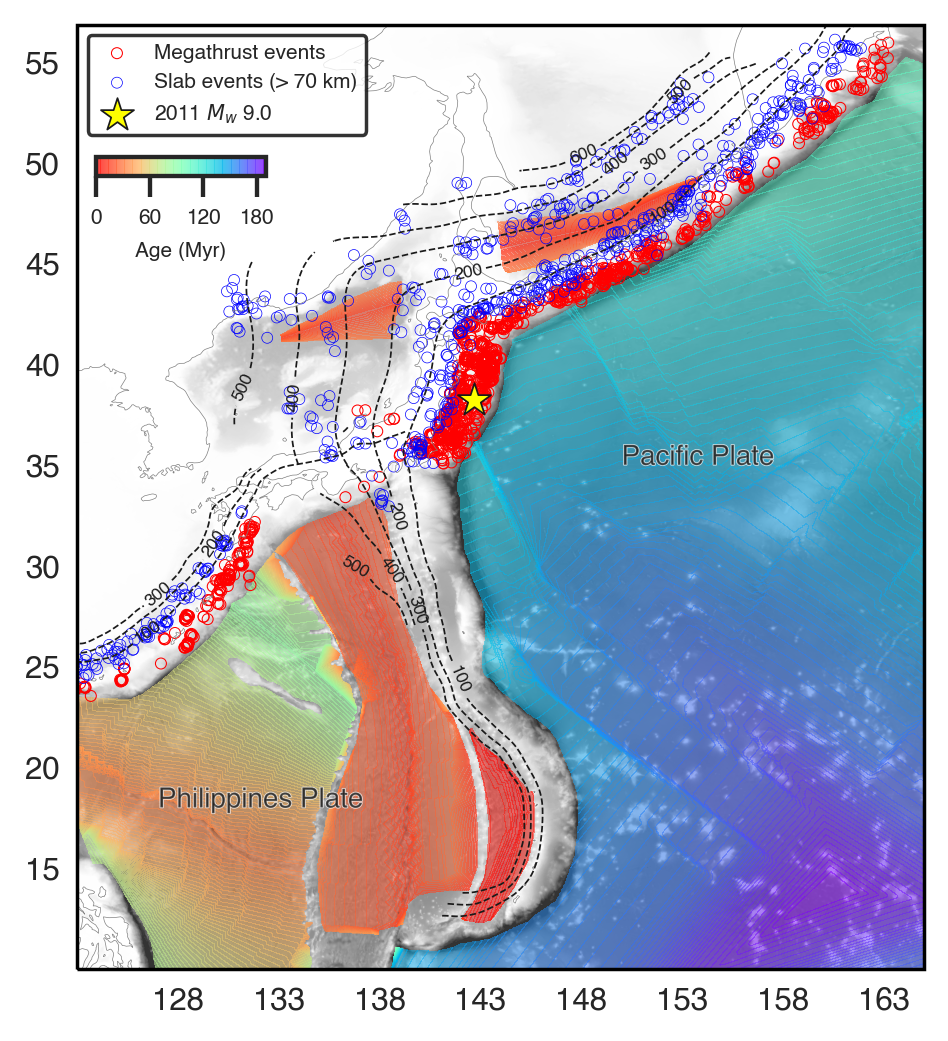

In [130]:
fig, ax = plt.subplots(dpi = 250, figsize=(5,5))

fig1 = ax

projection = cartopy.crs.PlateCarree()
fig1 = plt.axes(projection = projection)

fig1.set_extent([123, 165, 10, 55])


# g1 = fig1.gridlines(linewidth=0.5, color='gray', alpha=0.5, draw_labels = True)
gl = fig1.gridlines(linewidth = 0, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(123, 170, 5))
gl.ylocator = mticker.FixedLocator(np.arange(10, 65, 5))
gl.xlabels_top = False
gl.ylabels_right = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 9}
gl.xlabel_style = {'size': 9}


# Plot the topography data

vmin, vmax = -8000, 0
fig1.imshow(topography_data, extent=extent, origin='upper',
            alpha = 0.8, cmap='Greys_r',
            vmin=vmin, vmax=vmax,
            transform=cartopy.crs.PlateCarree()) # terrain


## plot slab contours
depth_levels=[0, 100, 200, 300, 400, 500, 600]

lw=0.5
# nankai ryukyu
contour_ryu = fig1.contour(lon_slab_ryu, lat_slab_ryu, depth_slab_ryu, levels=depth_levels,
                       colors='k', linestyles='dashed', linewidths=lw, transform=cartopy.crs.PlateCarree())
fig1.clabel(contour_ryu, inline=True, fmt='%d', fontsize=5, colors='k', rightside_up=True)


color = 'k'
# japan kuril kamchatka
contour_kk = fig1.contour(lon_slab_kk, lat_slab_kk, depth_slab_kk, levels=depth_levels,
                       colors=color, linestyles='dashed', linewidths=lw, transform=cartopy.crs.PlateCarree())
fig1.clabel(contour_kk, inline=True, fmt='%d', fontsize=5, colors=color, rightside_up=True)


# color = 'red'
# izu bonin
contour_izu = fig1.contour(lon_slab_izu, lat_slab_izu, depth_slab_izu, levels=depth_levels,
                       colors=color, linestyles='dashed', linewidths=lw, transform=cartopy.crs.PlateCarree())
fig1.clabel(contour_izu, inline=True, fmt='%d', fontsize=5, colors=color, rightside_up=True)


# Create a contour plot of the plate age data
contour_levels = range(0, 191, 1)
contour = fig1.contourf(lon, lat, age, cmap='rainbow_r',
                        levels=contour_levels,
                        vmin = 0, vmax = 190, alpha=0.5)

cbaxes = inset_axes(fig1, width="20%", height="2%", loc=2,
                   bbox_to_anchor=(0,-0.12,1,1), bbox_transform=fig1.transAxes) 
cbar = plt.colorbar(contour, ax=fig1, ticks=[0, 60, 120, 180], orientation='horizontal', cax=cbaxes)
size=6
cbar.set_label(label='Age (Myr)', size=size, weight='bold')
cbar.ax.tick_params(labelsize=size)


# Add coastlines without filled colors
fig1.add_feature(NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='grey', linewidth = 0.2, facecolor='none'  # Set facecolor to 'none'
))
    

###########


alpha = 0.7

fig1.text(127, 18, 'Philippines Plate', transform=ccrs.PlateCarree(), color='k',
          fontsize=8, rotation=0, alpha=alpha,
         path_effects = [path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

fig1.text(150, 35, 'Pacific Plate', transform=ccrs.PlateCarree(), color='k',
          fontsize=8, rotation=0, alpha=alpha,
         path_effects = [path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

# fontsize=4
# fig1.text(127, 23, 'Ryukyu Trench', transform=ccrs.PlateCarree(), color='black',
#           fontsize=fontsize, rotation=45, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# fig1.text(133, 30, 'Nankai Trough', transform=ccrs.PlateCarree(), color='black',
#           fontsize=fontsize, rotation=30, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# fig1.text(143.2, 35, 'Japan Trench', transform=ccrs.PlateCarree(), color='black',
#           fontsize=fontsize, rotation=70, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# fig1.text(150, 42, 'Kuril-Kamchatka Trench', transform=ccrs.PlateCarree(), color='black',
#           fontsize=fontsize, rotation=35, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# fig1.text(143, 27, 'Izu-Bonin Trench', transform=ccrs.PlateCarree(), color='black',
#           fontsize=fontsize, rotation=100, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# fig1.text(148.5, 14, 'Mariana Trench', transform=ccrs.PlateCarree(), color='black',
#           fontsize=fontsize, rotation=90, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

alpha = 0.7
size = 10
fig1.scatter(data_mthrust['LON'], data_mthrust['LAT'], s=size, marker='o',
                 facecolor='none', edgecolor='red', linewidths = 0.3, alpha=1, label='Megathrust events')

fig1.scatter(data_DW['LON'], data_DW['LAT'], s=size, marker='o',
                 facecolor='none', edgecolor='blue', linewidths = 0.2, alpha=1, label='Slab events (> 70 km)')

    
# ## plot 2011 hypocenter and rupture

# t1 = fig1.text(144, 37.5, '$M_w$ 9.0 (2011)', transform=ccrs.PlateCarree(), color='k',
#           fontsize=6, rotation=0, alpha=1,
#          path_effects = [path_effects.Stroke(linewidth=0.1, foreground='white'), path_effects.Normal()])

# t1.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white', lw=0))

data_great = data[(data['CLASS'] == 'MTHRUST') & (data['MW'] >= 8.5)]
fig1.scatter(data_great['LON'], data_great['LAT'],
             marker = '*', s = 100, c = 'yellow', alpha = 1,
             edgecolor = 'k', linewidths = 0.5, transform=cartopy.crs.PlateCarree(), label= '2011 $M_w$ 9.0')

# # year = int(data_great['year'])  # Convert 'year' to an integer
# fig1.text(data_great['LON'], data_great['LAT'], f'Magnitude: {data_great["MW"]}', fontsize=8,
#         color='white', ha='center', va='bottom', transform=cartopy.crs.PlateCarree())

# fig1.plot(rup_2011['LON'], rup_2011['LAT'], '-', c = 'red', linewidth = 1.5, alpha=1)
    
# fig1.axhline(y=36, color='k', linestyle='--', lw=0.5, label='Latitude -6°')
# fig1.axhline(y=39.5, color='k', linestyle='--', lw=0.5, label='Latitude -6°')

# fig1.axhline(y=40, color='k', linestyle='--', lw=0.5)
# fig1.axhline(y=44, color='k', linestyle='--', lw=0.5)
# fig1.axvline(x=133, color='k', linestyle='--', lw=0.5)
# fig1.axvline(x=140, color='k', linestyle='--', lw=0.5)

fontsize = 6
fig1.legend(loc = 'upper left',
            fontsize = fontsize,
            facecolor="white",
            edgecolor="black",
            markerscale=1)

# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/Japan-Map.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/Japan-Map-1.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

## 3D slabs

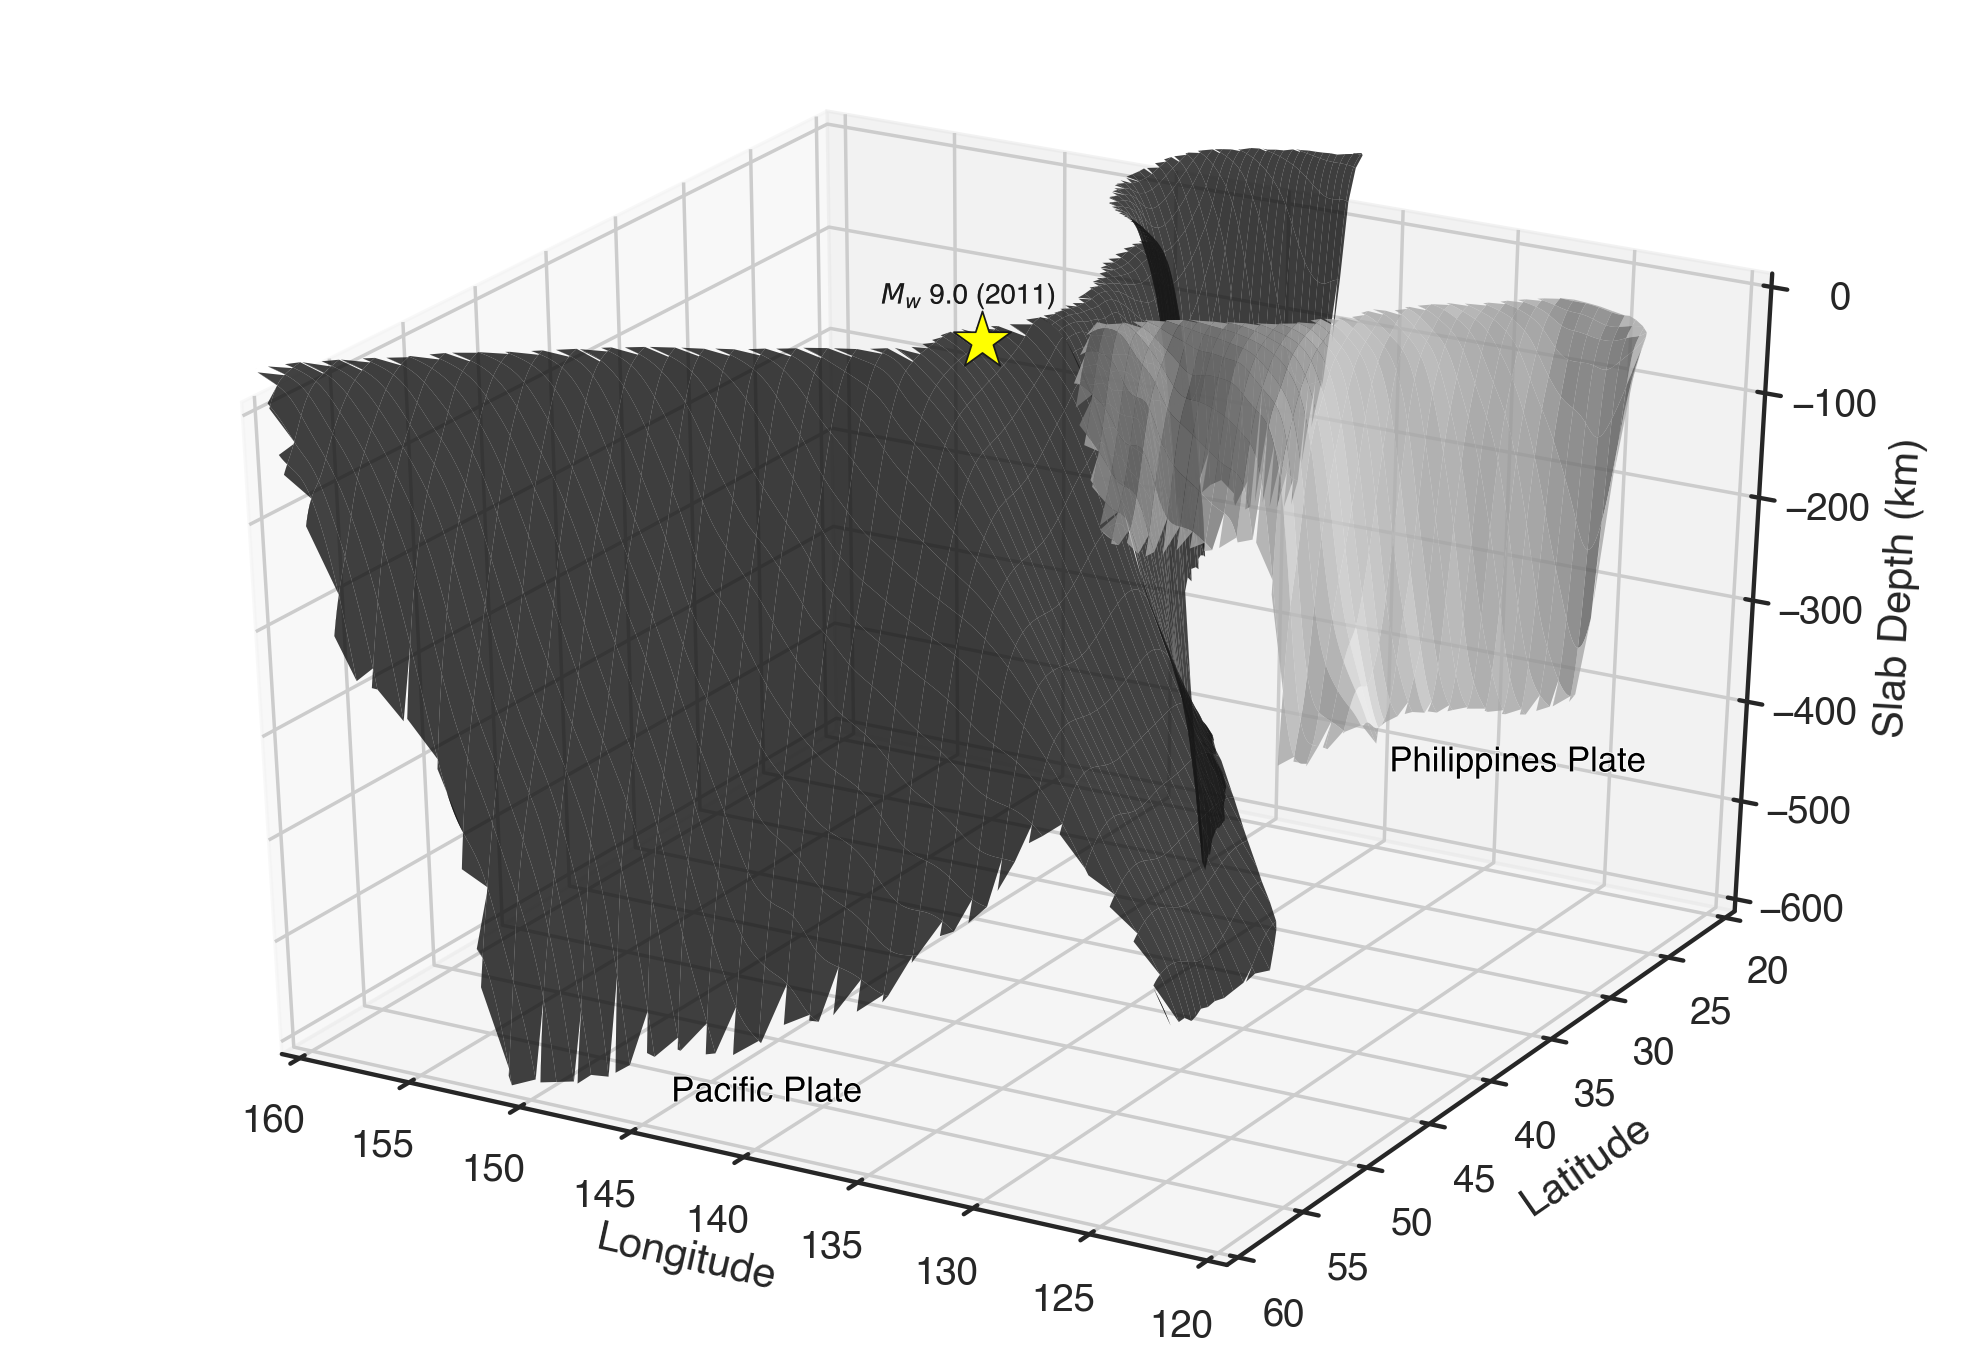

In [151]:
# Create a 3D figure
fig = plt.figure(figsize=(10, 7), dpi=250)
fig1 = fig.add_subplot(111, projection='3d')


# Plot the subduction slabs using surface plots (or plot_wireframe for lines)
izu_slab_surf = fig1.plot_surface(lon_slab_izu, lat_slab_izu, depth_slab_izu*-1,
                                  edgecolor='none', color='k', alpha=0.8)
japan_slab_surf = fig1.plot_surface(lon_slab_kk, lat_slab_kk, depth_slab_kk*-1,
                                  edgecolor='none', color='k', alpha=0.8)
ryu_slab_surf = fig1.plot_surface(lon_slab_ryu, lat_slab_ryu, depth_slab_ryu*-1,
                                edgecolor='none', color='white', alpha=0.8)

# Customize the plot
fig1.set_xlabel('Longitude')
fig1.set_ylabel('Latitude')
fig1.set_zlabel('Slab Depth (km)')
# ax.set_title('3D Subduction of Slabs along the Trench')

# Adjust the view angle for a better perspective
fig1.view_init(elev=30, azim=120)  # Adjust the elevation and azimuth angles

fig1.set_xlim(120, 160)
fig1.set_ylim(20, 60)
fig1.set_zlim(-600,0)

fontsize=10
fig1.text(150, 50, -700, 'Pacific Plate', color='black',
          fontsize=fontsize, rotation=0,
         path_effects = [path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

fig1.text(125, 38, -350, 'Philippines Plate', color='black',
          fontsize=fontsize, rotation=0,
         path_effects = [path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])


# # grey bands

# fig1.scatter(data_mthrust_grey['LON'], data_mthrust_grey['LAT'], data_mthrust_grey['DEPTH']*-1,
#              marker = '*', s = star, c = 'grey', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_grey['LON'], data_DW_grey['LAT'], data_DW_grey['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'grey', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

## 2011 event
mega_eq = data_mthrust[(data_mthrust['MW'] == data_mthrust.MW.max())]

fig1.scatter(mega_eq['LON'], mega_eq['LAT'], mega_eq['DEPTH']*-1,
             marker = '*', s = 300, c = 'yellow', alpha = 1,
             edgecolor = 'k', linewidths = 0.5)

## rupture
# fig1.plot(rup_2011['LON'], rup_2011['LAT'], '-', c = 'yellow', linewidth = 1.5, alpha=1)

fig1.text(146, 40, 20, '$M_w$ 9.0 (2011)', color='k',
          fontsize=8, rotation=0, alpha=1,
         path_effects = [path_effects.Stroke(linewidth=0.1, foreground='white'), path_effects.Normal()])



plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/3D-Japan-Map.png"
            , dpi = 500, transparent= True, bbox_inches='tight')

#### Overlay topo data